In [ ]:
import pandas as pd

In [ ]:
df= pd.read_csv("data.csv")
df['text'].head()

0    One of the best game music soundtracks - for a...
1    Batteries died within a year ...I bought this ...
2    works fine, but Maha Energy is betterCheck out...
3    Great for the non-audiophileReviewed quite a b...
4    DVD Player crapped out after one yearI also be...
Name: text, dtype: object

In [ ]:
from transformers import BertTokenizer

# Load the dataset from a CSV file
df = pd.read_csv('data.csv')

# Extract the text and annotation columns
text_annotation_df = df[['text', 'annotation']]

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize and preprocess the data
def preprocess_data(df, max_length=10):
    # Tokenize the text column with padding and truncation
    encoded_inputs = tokenizer(
        df['text'].tolist(),         # List of text inputs
        max_length=max_length,       # Maximum length for padding/truncation
        padding='max_length',        # Pad to the max length specified
        truncation=True,             # Truncate sequences longer than max_length
        return_tensors=None          # Return plain Python lists
    )

    # Add the preprocessed data back into the DataFrame
    df['input_ids'] = encoded_inputs['input_ids']
    df['attention_mask'] = encoded_inputs['attention_mask']

    return df

# Preprocess the dataframe
preprocessed_df = preprocess_data(text_annotation_df)

# Display the preprocessed dataframe
print(preprocessed_df)


In [ ]:
# Save the preprocessed dataframe to a CSV file
preprocessed_df.to_csv('preprocessed_data.csv', index=False)

In [ ]:
import os

# Get and print the current working directory
current_directory = os.getcwd()
print(f"Current working directory: {current_directory}")


Current working directory: C:\Users\Danish Computers


In [ ]:
import tensorflow as tf
import keras
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import numpy as np

In [ ]:
# Load the preprocessed data
preprocessed_df = pd.read_csv('preprocessed_data.csv')
preprocessed_df.tail(100)

,text,annotation,input_ids,attention_mask
69900,An amazing CDThe Riggley Road Stories CD is by...,0,"[101, 2019, 6429, 3729, 10760, 19838, 22971, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
69901,Reading for my little girl....She loves it.My ...,0,"[101, 3752, 2005, 2026, 2210, 2611, 1012, 1012...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
69902,Be careful openingThe third time I took the to...,0,"[101, 2022, 6176, 3098, 10760, 2353, 2051, 104...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
69903,Excellent iPod CaseI'm not sure why I don't se...,0,"[101, 6581, 26322, 2553, 2072, 1005, 1049, 202...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
69904,WORST BOOK EVERI really HATED this book. It wa...,1,"[101, 5409, 2338, 2412, 2072, 2428, 6283, 2023...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
...,...,...,...,...
69995,First of all...let me just say that Britney is...,1,"[101, 2034, 1997, 2035, 1012, 1012, 1012, 2292...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
69996,baby one more time is the only good thing on h...,1,"[101, 3336, 2028, 2062, 2051, 2003, 1996, 2069...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
69997,Not a very good album at all to be honest with...,1,"[101, 2025, 1037, 2200, 2204, 2201, 2012, 2035...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
69998,SlipLooks like this album is already starting ...,1,"[101, 7540, 4135, 6559, 2015, 2066, 2023, 2201...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"


In [ ]:
# Ensure that all elements in the 'input_ids' and 'attention_mask' columns are lists
X_input_ids = np.array([eval(x) for x in preprocessed_df['input_ids'].tolist()], dtype=np.int32)
X_attention_mask = np.array([eval(x) for x in preprocessed_df['attention_mask'].tolist()], dtype=np.int32)
y = np.array(preprocessed_df['annotation'], dtype=np.int32)

In [ ]:
# Split data into training and validation sets
X_train_ids, X_test_ids, X_train_mask, X_test_mask, y_train, y_test = train_test_split(
    X_input_ids, X_attention_mask, y, test_size=0.2, random_state=42
)

In [ ]:
# Define the input layers
input_ids = Input(shape=(10,), dtype='int32', name='input_ids')
attention_mask = Input(shape=(10,), dtype='int32', name='attention_mask')

In [ ]:
# Embedding layer
embedding_layer = Embedding(input_dim=30522, output_dim=128)(input_ids)

# LSTM layers with adjusted units
lstm_out = LSTM(32, return_sequences=True)(embedding_layer) # single-directional

lstm_out = LSTM(32)(lstm_out) #single-directional

# Dense layers
dense_out = Dense(32, activation='relu')(lstm_out)

# Output layer
output = Dense(1, activation='sigmoid')(dense_out)  # binary classification

# Create the model
model = Model(inputs=[input_ids, attention_mask], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "functional_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)        │ (None, 10)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_54 (Embedding)      │ (None, 10, 128)           │       3,906,816 │ input_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_80 (LSTM)                │ (None, 10, 32)            │          20,608 │ embedding_54[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_81 (LSTM)                │ (None, 32)                │           8,320 │ lstm_80[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_94 (Dense)              │ (None, 32)                │           1,056 │ lstm_81[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ attention_mask (InputLayer)   │ (None, 10)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_95 (Dense)              │ (None, 1)                 │              33 │ dense_94[0][0]             │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 3,936,833 (15.02 MB)

 Trainable params: 3,936,833 (15.02 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history = model.fit(
    [X_train_ids, X_train_mask], y_train,  # Provide both inputs as a list
    validation_data=([X_test_ids, X_test_mask], y_test),
    epochs=5,
    batch_size=32
)

Epoch 1/5
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 85s 46ms/step - accuracy: 0.7588 - loss: 0.4708 - val_accuracy: 0.8207 - val_loss: 0.3859
Epoch 2/5
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 81s 46ms/step - accuracy: 0.8661 - loss: 0.2961 - val_accuracy: 0.8206 - val_loss: 0.3837
Epoch 3/5
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 81s 46ms/step - accuracy: 0.9018 - loss: 0.2284 - val_accuracy: 0.8179 - val_loss: 0.4182
Epoch 4/5
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 82s 47ms/step - accuracy: 0.9302 - loss: 0.1701 - val_accuracy: 0.8182 - val_loss: 0.5082
Epoch 5/5
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 79s 45ms/step - accuracy: 0.9490 - loss: 0.1277 - val_accuracy: 0.8109 - val_loss: 0.5688


In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate([X_test_ids, X_test_mask], y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8125 - loss: 0.5660
Test Loss: 0.5688318610191345
Test Accuracy: 0.8109285831451416


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score

# Predict on the test set
y_pred = model.predict([X_test_ids, X_test_mask])
y_pred = (y_pred > 0.5).astype("int32")

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Compute and print individual metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.81      0.81      7147
           1       0.81      0.81      0.81      6853

    accuracy                           0.81     14000
   macro avg       0.81      0.81      0.81     14000
weighted avg       0.81      0.81      0.81     14000

Precision: 0.8063
Recall: 0.8078
F1 Score: 0.8071


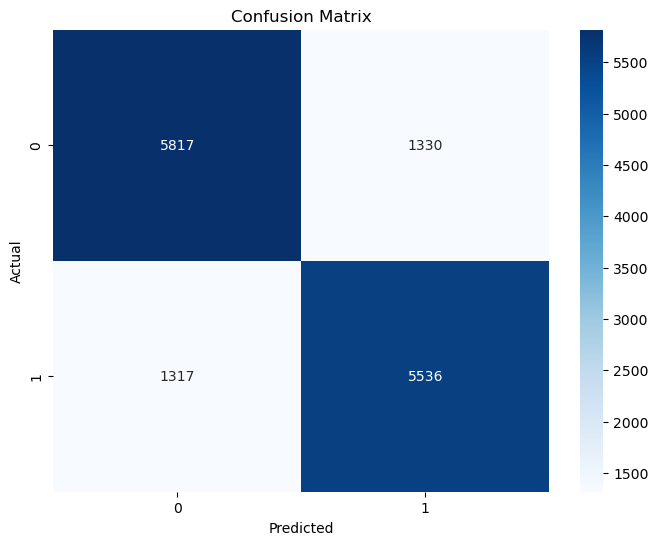

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
model.save('saved_model/text_moderation_model.h5')  # Save the entire model

In [ ]:
import pickle

# Save the tokenizer
with open('saved_model/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)


In [ ]:
import numpy as np
import pickle
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model('saved_model/text_moderation_model.h5')

# Load the saved tokenizer
with open('saved_model/tokenizer.pkl', 'rb') as f:
    loaded_tokenizer = pickle.load(f)

# Sample sentence
new_texts = ["The product is excellent and I am very satisfied"]
#new_texts = ["The product is very bad and I am not satisfied"]

# Tokenize and preprocess the text
encoded_inputs = loaded_tokenizer(
    new_texts,
    max_length=10,  # Use the same max_length as during training
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)



X_test_ids_new = np.array(encoded_inputs['input_ids'], dtype=np.int32)
X_attention_mask_new = np.array(encoded_inputs['attention_mask'], dtype=np.int32)

# Predict using the loaded model
predictions = loaded_model.predict([X_test_ids_new, X_attention_mask_new])

# Convert prediction to "negative" or "positive"
threshold = 0.5  # Typical threshold for binary classification
prediction_label = ["positive" if pred > threshold else "negative" for pred in predictions]

print(new_texts)
print(f"Prediction: {prediction_label[0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
['The product is excellent and I am very satisfied']
Prediction: negative
